<a href="https://colab.research.google.com/github/takumaosada/COVID-19-Basic-Analysis/blob/master/signate_covid19_case_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データの読み込み

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
%matplotlib inline
!pip install japanize_matplotlib
!pip install category_encoders
import japanize_matplotlib
import category_encoders as ce
import gspread
import re
import itertools
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from oauth2client.client import GoogleCredentials
from google.colab import auth
import warnings
auth.authenticate_user()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [3]:
singatecasefilelink='https://docs.google.com/spreadsheets/d/1VLSA8q2zPCbaTDXXcMsxK0HRZlFRVH7_x0rLd4Z7Jk8/edit#gid=960903158'
book = gc.open_by_url(singatecasefilelink)
casedata = book.worksheet('罹患者').get_all_values()
casedf = pd.DataFrame(casedata)

In [4]:
#データフレームを整理していく
area_dict = dict(zip(casedf.index, casedf.iloc[0]))
renamed_df = casedf.rename(columns=area_dict)
df = renamed_df.drop(0)
df =df.drop_duplicates()
df.drop(df.index[-1]).tail()

,都道府県コード,症例番号,都道府県症例番号,発症日,確定日,公表日,受診都道府県,居住都道府県,居住市区町村,年代,性別,職業,ステータス,退院済ﾌﾗｸﾞ,基礎疾患ﾌﾗｸﾞ,症状・経過,症状一覧,行動歴,濃厚接触者状況,濃厚接触場所,海外渡航歴ﾌﾗｸﾞ,ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ,情報源,備考,罹患者関係_記入済ﾌﾗｸﾞ,罹患者トランザクション_記入済ﾌﾗｸﾞ,Relation1,Relation2,Transaction
16156,50,1,50-1,,,,中部国際空港,,,,,,,,,,,,,,,,,,0,0,,,
16157,51,27,51-27,,2020/03/27,,関西国際空港,不明,,20 - 29,男性,,無症状,0,,,,,,,,,https://www.mhlw.go.jp/stf/newpage_10539.html,,0,0,,,
16158,51,28,51-28,,2020/03/27,,関西国際空港,兵庫県,,非公表,男性,,無症状,0,,,,,,,,,https://www.mhlw.go.jp/stf/newpage_10539.html,,0,0,,,
16159,51,52,51-52,,2020/03/30,,関西国際空港,不明,,30 - 39,男性,,無症状,0,,,,,,,,,https://www.mhlw.go.jp/stf/newpage_10638.html,3/29ドイツから帰国,0,0,,,
16160,51,53,51-53,,2020/03/30,,関西国際空港,不明,,40 - 49,男性,,無症状,0,,,,,,,,,https://www.mhlw.go.jp/stf/newpage_10638.html,3/29オランダから帰国,0,0,,,


# データの確認

In [5]:
df.describe()

,都道府県コード,症例番号,都道府県症例番号,発症日,確定日,公表日,受診都道府県,居住都道府県,居住市区町村,年代,性別,職業,ステータス,退院済ﾌﾗｸﾞ,基礎疾患ﾌﾗｸﾞ,症状・経過,症状一覧,行動歴,濃厚接触者状況,濃厚接触場所,海外渡航歴ﾌﾗｸﾞ,ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ,情報源,備考,罹患者関係_記入済ﾌﾗｸﾞ,罹患者トランザクション_記入済ﾌﾗｸﾞ,Relation1,Relation2,Transaction
count,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161
unique,51,5175,16158,218,176,178,51,73,791,12,6,121,8,6,6,5995,1812,2907,3984,226,9,4,3232,1336,2,2,1793,3142,229
top,13,1,12-621,非公表,,2020/04/11,東京都,東京都,,50 - 59,男性,,,,,,,,,,,,,,0,0,,,
freq,5162,47,2,5205,4784,674,5162,3836,4638,2636,8682,6541,9412,8836,11928,8179,10814,9974,8403,12728,10125,10885,4091,12960,11874,15934,12367,12368,13890


In [6]:
# nullの値があるかどうか確認
df.isnull().sum()

都道府県コード                  0
症例番号                     0
都道府県症例番号                 0
発症日                      0
確定日                      0
公表日                      0
受診都道府県                   0
居住都道府県                   0
居住市区町村                   0
年代                       0
性別                       0
職業                       0
ステータス                    0
退院済ﾌﾗｸﾞ                  0
基礎疾患ﾌﾗｸﾞ                 0
症状・経過                    0
症状一覧                     0
行動歴                      0
濃厚接触者状況                  0
濃厚接触場所                   0
海外渡航歴ﾌﾗｸﾞ                0
ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ    0
情報源                      0
備考                       0
罹患者関係_記入済ﾌﾗｸﾞ            0
罹患者トランザクション_記入済ﾌﾗｸﾞ      0
Relation1                0
Relation2                0
Transaction              0
dtype: int64

In [7]:
# naの値があるかどうか確認
df.isna().sum()

都道府県コード                  0
症例番号                     0
都道府県症例番号                 0
発症日                      0
確定日                      0
公表日                      0
受診都道府県                   0
居住都道府県                   0
居住市区町村                   0
年代                       0
性別                       0
職業                       0
ステータス                    0
退院済ﾌﾗｸﾞ                  0
基礎疾患ﾌﾗｸﾞ                 0
症状・経過                    0
症状一覧                     0
行動歴                      0
濃厚接触者状況                  0
濃厚接触場所                   0
海外渡航歴ﾌﾗｸﾞ                0
ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ    0
情報源                      0
備考                       0
罹患者関係_記入済ﾌﾗｸﾞ            0
罹患者トランザクション_記入済ﾌﾗｸﾞ      0
Relation1                0
Relation2                0
Transaction              0
dtype: int64

# データクリーニング


In [8]:
#性別でのデータクリーニングを行う
df = df[(df['性別'] == "男性") | (df['性別'] == '女性')]
#年代でのデータクリーニングを行う
df = df[(df['年代'] != "51 - 59") & (df['年代'] != '非公表') & (df['年代'] != '')]
#海外渡航歴でのデータクリーニングを行う
df["海外渡航歴ﾌﾗｸﾞ"] = df["海外渡航歴ﾌﾗｸﾞ"].str.replace("非公表", "").str.replace("１", "1").str.replace("０", "0").str.replace("他自治体で調査中", "").str.replace("千葉県で調査中", "").str.replace("不明", "")
#ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞでのデータクリーニングを行う
df["ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ"] = df["ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ"].str.replace("非公表", "").str.replace("１", "1")

In [9]:
for column_name, item in df.iteritems():
    print(column_name, type(column_name))
    print(df[column_name].value_counts())
    print('========================\n')

都道府県コード <class 'str'>
13    5143
27    1778
14    1282
11     998
1      982
12     753
28     698
40     665
23     508
26     351
17     293
16     212
8      168
21     151
10     149
34     147
47     142
18     122
4       88
15      82
25      82
7       81
38      79
39      74
29      74
6       66
9       55
30      54
20      53
22      49
44      49
19      48
43      47
41      45
24      45
37      28
2       27
32      24
35      21
49      19
42      17
45      16
5       16
33      14
48       8
46       6
36       5
31       3
51       3
Name: 都道府県コード, dtype: int64

症例番号 <class 'str'>
1       46
2       45
6       44
5       44
3       44
        ..
4506     1
4866     1
4896     1
2013     1
3347     1
Name: 症例番号, Length: 5159, dtype: int64

都道府県症例番号 <class 'str'>
44-40      2
12-621     2
21-150     2
14-930     1
40-512     1
          ..
47-72      1
40-321     1
27-703     1
14-370     1
14-1149    1
Name: 都道府県症例番号, Length: 15817, dtype: int64

発症日 <class 'str'>
非

In [10]:
#性別をencodeする
import category_encoders as ce
df_gender = df['性別']
list_cols = ['性別']
ce_ohe = ce.OrdinalEncoder(cols=list_cols,handle_unknown='impute')
df['性別'] = ce_ohe.fit_transform(df_gender)

In [11]:
#受診都道府県をencodeする
df_city = df['受診都道府県']
list_cols = ['受診都道府県']
ce_ohe = ce.OrdinalEncoder(cols=list_cols,handle_unknown='impute')
df['受診都道府県'] = ce_ohe.fit_transform(df_city)

In [12]:
#居住都道府県をencodeする
df_city = df['居住都道府県']
list_cols = ['居住都道府県']
ce_ohe = ce.OrdinalEncoder(cols=list_cols,handle_unknown='impute')
df['居住都道府県'] = ce_ohe.fit_transform(df_city)

In [13]:
#年代をencodeする
df_age = df['年代']
list_cols = ['年代']
ce_ohe = ce.OrdinalEncoder(cols=list_cols,handle_unknown='impute')
df['年代'] = ce_ohe.fit_transform(df_age)

In [14]:
#ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞをencodeする
df_diamond = df['ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ']
list_cols = ['ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ']
ce_ohe = ce.OrdinalEncoder(cols=list_cols,handle_unknown='impute')
df['ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ'] = ce_ohe.fit_transform(df_diamond)

In [15]:
df_foreign = df['海外渡航歴ﾌﾗｸﾞ']
#海外渡航歴ﾌﾗｸﾞをencodeする
list_cols = ['海外渡航歴ﾌﾗｸﾞ']
ce_ohe = ce.OrdinalEncoder(cols=list_cols,handle_unknown='impute')
df['海外渡航歴ﾌﾗｸﾞ'] = ce_ohe.fit_transform(df_foreign)

# PairPlotで相関を確認する

In [16]:
# sns.pairplot(df)

In [17]:
#職業とステータスの関係性
job_status_df = df[['職業', 'ステータス']]
job_status_df = job_status_df.groupby('職業').filter(lambda x: len(x) > 100)

df_status = job_status_df['ステータス']
list_cols = ['ステータス']
ce_ohe = ce.OrdinalEncoder(cols=list_cols,handle_unknown='impute')
job_status_df['ステータス'] = ce_ohe.fit_transform(df_status)

job_status_df['ステータス'] = job_status_df['ステータス'].astype(float)

In [18]:
# fig, axs = plt.subplots(15, 1, figsize=(10, 10))
# for count, (index, value) in enumerate(job_status_df['職業'].value_counts().iteritems(), 1):
#   title = str(index) + ' (標本数: ' + str(value) +  ")"
#   dataframe = job_status_df[job_status_df['職業'] == index]
#   axs[count].set_title(title)
#   axs[count].pie(dataframe["ステータス"])

# plt.show()

# Xgboostを用いた分析

## 症状のデータの読み込み

In [19]:
singatecasefilelink='https://docs.google.com/spreadsheets/d/1tnxt17rtmFnG4UNX8DXVXGUhCcL7-cXHE3hhoOpvfsk/edit#gid=577718303'
symptom_book = gc.open_by_url(singatecasefilelink)
symptom_data = symptom_book.worksheet('症状').get_all_values()
symptomdf = pd.DataFrame(symptom_data)

In [20]:
area_dict = dict(zip(symptomdf.index, symptomdf.iloc[0]))
renamed_df = symptomdf.rename(columns=area_dict)
symptomdf = renamed_df.drop(0)
symptomdf =symptomdf.drop_duplicates()
symptomdf.drop(symptomdf.index[-1]).tail()

,都道府県コード,症例番号,都道府県症例番号,症状・経過,日付,症状,確認済ﾌﾗｸﾞ
63162,27,2464,27-2464,非公表,-,-,-
63164,27,2465,27-2465,非公表,-,-,-
63166,27,2466,27-2466,非公表,-,-,-
63168,27,2467,27-2467,非公表,-,-,-
63170,27,2468,27-2468,非公表,-,-,-


In [21]:
symptomdf = symptomdf[(symptomdf['症状'] != "-")]

In [22]:
symptomdf

,都道府県コード,症例番号,都道府県症例番号,症状・経過,日付,症状,確認済ﾌﾗｸﾞ
2,,,,,2020/01/26,icd=R05;咳,1
3,,,,,2020/01/26,icd=R509;発熱,1
4,,,,,2020/01/27,icd=J189;肺炎,1
5,,,,,2020/01/27,受診,1
6,,,,,2020/01/27,入院,1
...,...,...,...,...,...,...,...
60032,,,,,2020/07/14,icd=R509;発熱,
60033,,,,,2020/07/14,icd=R05;咳,
60034,,,,,2020/07/14,受診,
60035,,,,,2020/07/15,入院,


In [23]:
symptoms = symptomdf["症状"].unique()
symptoms_list = list()
for element in symptoms:
  elements = re.split('[;，]', element)
  symptoms_list.append(elements)

In [24]:
unique_symptons_list = list(itertools.chain.from_iterable(symptoms_list))
unique_symptons_list = list(set(unique_symptons_list))

In [25]:
#不要な要素を取り除く
# 検査しないとわからない項目は取り除く
# 今回は死亡、受診、入院、退院、肺炎を取り除く
# 追加で呼吸困難は影響が大きすぎるので排除する
cleaned_symptoms_list = list()
for element in unique_symptons_list:
  if not ("icd" in element or "受診" in element or "死亡" in element):
    if not ("入院" in element or "肺炎" in element or "退院" in element or "呼吸困難" in element):
        cleaned_symptoms_list.append(element)

In [26]:
cleaned_symptoms_list

['',
 '胃腸疾患',
 '咳',
 '急性耳痛',
 '脱水症',
 'アレルギー',
 '嗅覚異常',
 '喉頭炎',
 '敗血症',
 '肋骨痛',
 '咽頭痛',
 '胃痛',
 'アデノウイルス感染症',
 'ほてり',
 '頭痛',
 '関節痛',
 '嗅覚障害',
 '鼻閉感',
 '聴覚障害',
 '意識障害',
 '倦怠感',
 '異常喀痰',
 '胸痛',
 'めまい',
 '発音障害',
 'くしゃみ',
 '敗血症性ショック',
 '嗄声',
 '悪寒戦慄',
 '鼻閉',
 '腎不全',
 '花粉症',
 '胸やけ',
 '不安障害',
 '聴覚異常',
 '血尿',
 '急性鼻炎',
 '健康相談',
 'ウイルス感染症',
 '神経痛',
 'そう痒',
 '喘鳴',
 '咽頭異常感症',
 '発熱',
 '耳鳴症',
 '頚部腫脹',
 '後頭部痛',
 '動悸',
 '悪心',
 '吐血',
 'よう',
 '味覚減退症',
 '骨折',
 '特発性拡張型心筋症',
 '発疹',
 '悪寒',
 '味覚異常',
 '胸部不快感',
 '筋肉痛',
 '嚥下障害',
 '腰痛症',
 '頚部痛',
 '乏尿',
 '鼻痛',
 '微熱',
 'ピリピリ感',
 '鼻漏',
 '扁桃炎',
 '喀痰',
 '脱力感',
 '末梢循環障害',
 '四肢しびれ',
 '肺野異常陰影',
 '血腫',
 '全身痛',
 '発汗障害',
 '全身倦怠感',
 '背部痛',
 '腰殿部痛',
 '耳痛症',
 '腰腹痛',
 '脂質異常症',
 '前胸部痛',
 '貧血',
 '項部痛',
 '筋力低下',
 '息切れ',
 '外傷',
 '急性上気道炎',
 '下肢しびれ',
 '心配',
 '結膜炎',
 '摂食機能障害',
 '肩こり',
 '拡張相肥大型心筋症',
 'コロナウイルス感染症',
 '胸部異常陰影',
 '心不全',
 '気管支炎',
 '下腹痛',
 '鼻汁',
 '胆石性急性胆のう炎',
 '湿疹',
 '食欲不振',
 '摂食障害',
 '口渇症',
 '喉頭痛',
 '肝機能障害',
 '口内炎',
 '腹痛症',
 '体力低下',
 '寝汗',
 '尿路感染症',
 '嘔気',
 '眼痛',
 'かぜ',
 '

## データの整理

In [27]:
!pip install xgboost
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.display import clear_output

In [28]:
df_new = df[["都道府県コード", "年代", "性別", "ステータス", "症状一覧"]]

In [29]:
# ステータスは`非公開`や``をdropし、死亡を４、重症を3、中等症を２、軽症、無症状を1とする
df_new = df_new[(df['ステータス'] == "重症") | (df['ステータス'] == '軽症') | (df['ステータス'] == '死亡') | (df['ステータス'] == '無症状') | (df['ステータス'] == '中等症')]
df_new["ステータス"] = df_new["ステータス"].str.replace("重症", "1").str.replace("死亡", "1").str.replace("中等症", "0").str.replace("軽症", "0").str.replace("無症状", "0")
df_new["ステータス"] = df_new["ステータス"].astype(int)

In [30]:
# 症状の一覧の配列を作成する
# dfの症状一覧から作成を試みる
import re
import itertools
symptom_array = df_new["症状一覧"].unique()
symptom_list = list()
for element in symptom_array:
  elements = re.split('[;、・\n :\r，,]', element)
  symptom_list.append(elements)

In [31]:
unique_symptons = list(itertools.chain.from_iterable(symptom_list))
unique_symptons = list(set(unique_symptons))

#不要な要素を取り除く
cleaned_symptom_list = list()
for element in unique_symptons:
  if not ("(" in element or ")" in element or "℃" in element or "度" in element or "）" in element or "（" in element or "。" in element):
    if not ("4" in element or "20" in element or "～" in element or "D" in element or "なし" in element):
      cleaned_symptom_list.append(element)

In [32]:
cleaned_symptom_list

['',
 '覚障害',
 '基礎疾患あり',
 '咳',
 '全員倦怠感',
 '下気道炎',
 '嗅覚異常',
 '食欲低下',
 '喉の違和',
 '敗血症',
 '咽頭違和感',
 '軽症',
 '肋骨痛',
 '咽頭痛',
 '頭痛',
 '肺の痛み',
 '中等症',
 '下痢症状',
 '胸部圧迫感',
 '腹声',
 '関節痛',
 '嗅覚障害',
 '鼻閉感',
 '呼吸困難',
 '意識障害',
 '倦怠感',
 '関節筋肉',
 '胸痛',
 'めまい',
 '臭覚障害',
 '嗅覚障害のみ',
 '非公表',
 '咳症状',
 '胸部痛み',
 '鼻閉',
 '嗄声',
 '病状は重症',
 '臭覚',
 '-',
 'せき',
 '聴覚異常',
 '肺炎倦怠感',
 '間質性肺炎',
 '労作時の息切れ',
 '無症状',
 '喘鳴',
 '肺炎疑い',
 '発熱',
 '熱感',
 'ふらつき',
 '足腰痛',
 '重篤な肺炎',
 '眩暈',
 '鼻',
 '間接筋肉',
 '動悸',
 '吐血',
 '味覚異常のみ',
 '息苦しさ',
 '倦怠',
 '全身の痛み',
 '呼吸苦',
 '関節筋肉痛',
 '酸素投与',
 '悪寒',
 '左胸部痛',
 '味覚異常',
 '胸部不快感',
 '臭覚異常',
 '筋肉痛',
 '解熱し',
 '咽頭通',
 '感',
 '微熱',
 '月',
 '喀痰',
 '吸気時の胸部痛',
 '肩や足の強い痛み',
 '痰',
 '全身痛',
 '全身倦怠感',
 '間接筋肉痛',
 '背部痛',
 '関節',
 '肺炎像',
 '咳肺炎',
 '喉の違和感',
 'ＣＴ肺炎像',
 '咳呼吸苦',
 '息切れ',
 '死亡',
 '呼吸',
 '倦',
 '胸部違和感',
 '酸素投与中',
 '後頚部痛',
 '体動困難',
 '上気道炎',
 '発熱\u3000咳味覚障害',
 '味覚嗅覚障害',
 '熱',
 '異常',
 '痛',
 '：',
 '鼻汁',
 '症状無し',
 '肺炎',
 '呼吸困難感',
 '食欲不振',
 '咽頭の違和',
 '鼻づまり',
 '肺炎像あり',
 '下痢',
 'むかつき',
 '喉頭痛',
 '死因',
 '呼吸困難あり',
 '怠',
 '

In [33]:
for element in cleaned_symptoms_list:
  df_new[element] = df_new["症状一覧"].str.contains(element)

In [34]:
df_new["都道府県コード"] = df_new["都道府県コード"].astype(int)

In [35]:
df_new.dtypes

都道府県コード     int64
年代          int64
性別          int64
ステータス       int64
症状一覧       object
            ...  
高血圧症         bool
多尿           bool
嘔吐症          bool
胃腸炎          bool
下痢症          bool
Length: 169, dtype: object

In [36]:
# 症状一覧をdropする
df_new = df_new.drop('症状一覧', axis=1)

In [37]:
params1 = {
    'n_estimators': 5000,
    'max_depth': 7,
    'objective':'reg:linear',
    'min_child_weight': 4,
    'eta': 0.07,
    'eval_metric': 'mae',
}

params2 = {
    'n_estimators': 5000,
    'max_depth': 7,
    'objective':'reg:linear',
    'min_child_weight': 4,
    'eta': 0.07,
    'eval_metric': 'auc',
}

kfold = KFold(n_splits=3)
stratifiedkfold = StratifiedKFold(n_splits=3)

In [38]:
def plot_xgboost_result(df):
  # モデルの作成(xgboost)
  x_train, x_test, y_train, y_test = train_test_split(df.drop('都道府県コード', axis=1).drop(['ステータス'], axis=1), df['ステータス'], stratify=df['ステータス'], test_size=0.3, random_state=0)

  dtrain = xgb.DMatrix(x_train, label=y_train)
  dtest = xgb.DMatrix(x_test, label=y_test)

  evals = [(dtrain, 'train'), (dtest, 'test')]

  evals_result = {}

  model1= xgb.train(
      params1,
      dtrain,
      num_boost_round=5000,
      evals=evals,
      early_stopping_rounds=30,
      evals_result=evals_result,
          )
  clear_output()

  y_pred = model1.predict(dtest)
  y_true = y_test.values

  train_metric = evals_result['train']['mae']
  eval_metric = evals_result['test']['mae']
  fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(24,15))
  axes[0,0].plot(train_metric, label='train mae')
  axes[0,0].plot(eval_metric, label='test mae', linestyle='dashed')
  axes[0,0].grid()
  axes[0,0].legend()
  axes[0,0].set_xlabel('学習回数')
  axes[0,0].set_ylabel('平均絶対誤差')

  xgb.plot_importance(model1, ax=axes[0,1], importance_type='gain', title='項目の重要度', show_values=False)
  axes[0,1].set_ylabel("項目")

  evals = [(dtrain, 'train'), (dtest, 'test')]

  evals_result = {}

  # モデルの作成(AUC)
  model2 = xgb.train(
      params2,
      dtrain,
      num_boost_round=5000,
      evals=evals,
      early_stopping_rounds=30,
      evals_result=evals_result,
          )
  clear_output()

  check = model2.predict(dtest)
  fpr, tpr, thresholds = roc_curve(y_true, check)
  axes[1,0].plot(fpr, tpr, marker='o')
  axes[1,0].set_xlabel('FPR: False positive rate')
  axes[1,0].set_ylabel('TPR: True positive rate')
  axes[1,0].grid()

  history = xgb.cv(params1, dtrain, num_boost_round=200, early_stopping_rounds=10, nfold=10, verbose_eval=False, stratified=True)
  train_metric = history['train-mae-mean']
  eval_metric = history['test-mae-mean']
  axes[1,1].plot(train_metric, label='train mae')
  axes[1,1].plot(eval_metric, label='eval mae')
  axes[1,1].grid()
  axes[1,1].legend()
  axes[1,1].set_xlabel('round')
  axes[1,1].set_ylabel('mae')
  print("重症,死亡の患者の数", df['ステータス'].value_counts()[1])
  print("AUCのベストスコア", model2.best_score)

In [39]:
def cross_validation(df):
  x = df.drop('都道府県コード', axis=1).drop(['ステータス'], axis=1)
  y = df['ステータス']
  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=0)
  model = LogisticRegression().fit(x_train, y_train)
  test_data_score = model.score(x_test, y_test)
  kfold_scores = cross_val_score(model, x, y, cv=kfold)
  stratified_kfold_score = cross_val_score(model, x, y, cv=stratifiedkfold)
  print("テストデータのスコア", test_data_score)
  print("交差検証のスコア平均", kfold_scores.mean())
  print("層化k分割交差検証のスコア平均", stratified_kfold_score.mean())

## 全体

[15:27:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:27:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:27:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:27:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:27:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:27:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:27:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:27:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

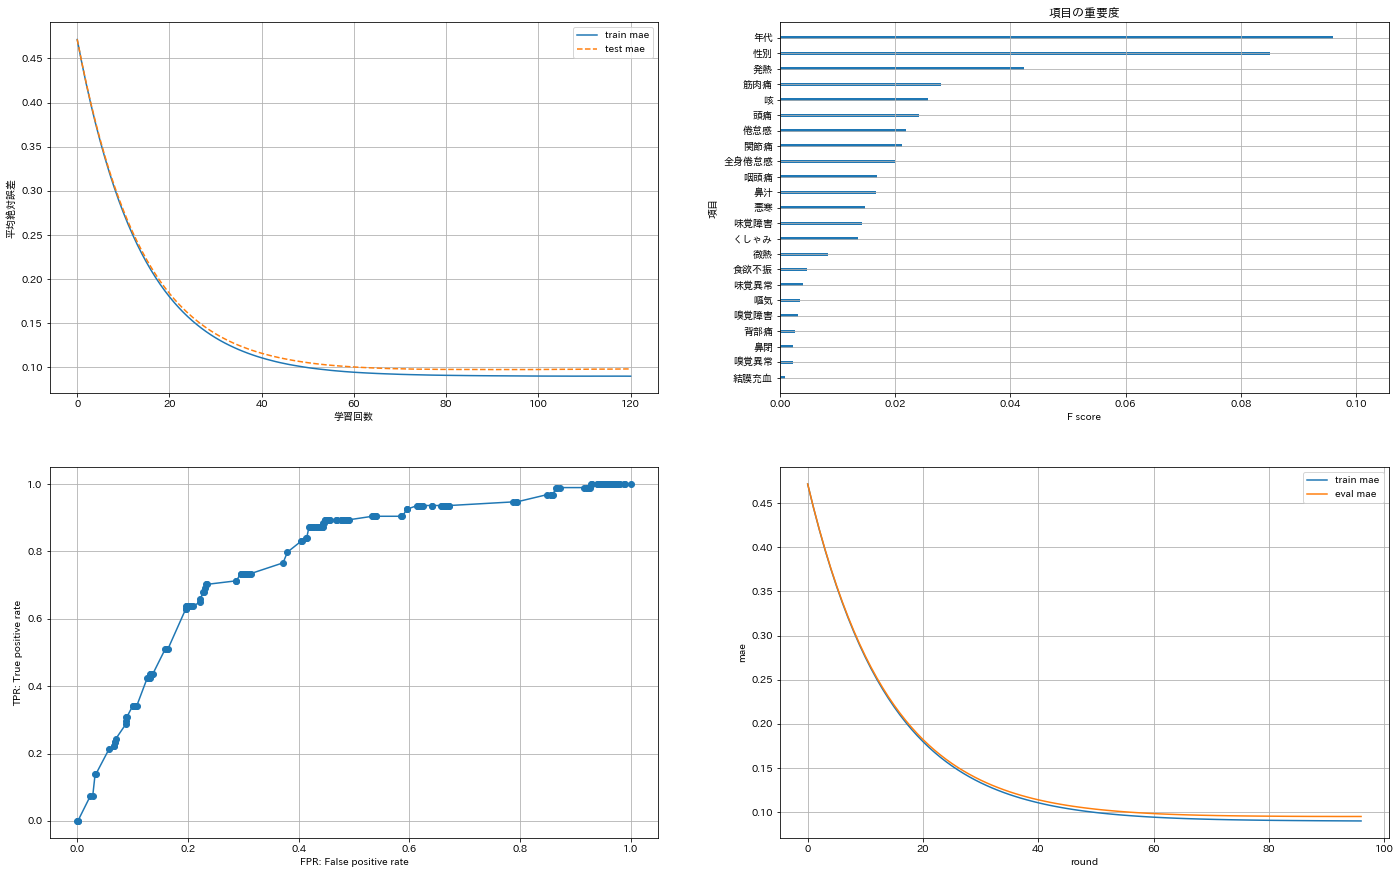

In [40]:
# 都道府県の項目は外す
plot_xgboost_result(df_new)

In [41]:
warnings.filterwarnings('ignore')
cross_validation(df_new)

テストデータのスコア 0.9457900807381776
交差検証のスコア平均 0.9459900293545154
層化k分割交差検証のスコア平均 0.9459927265534742


## 東京のみ

[15:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

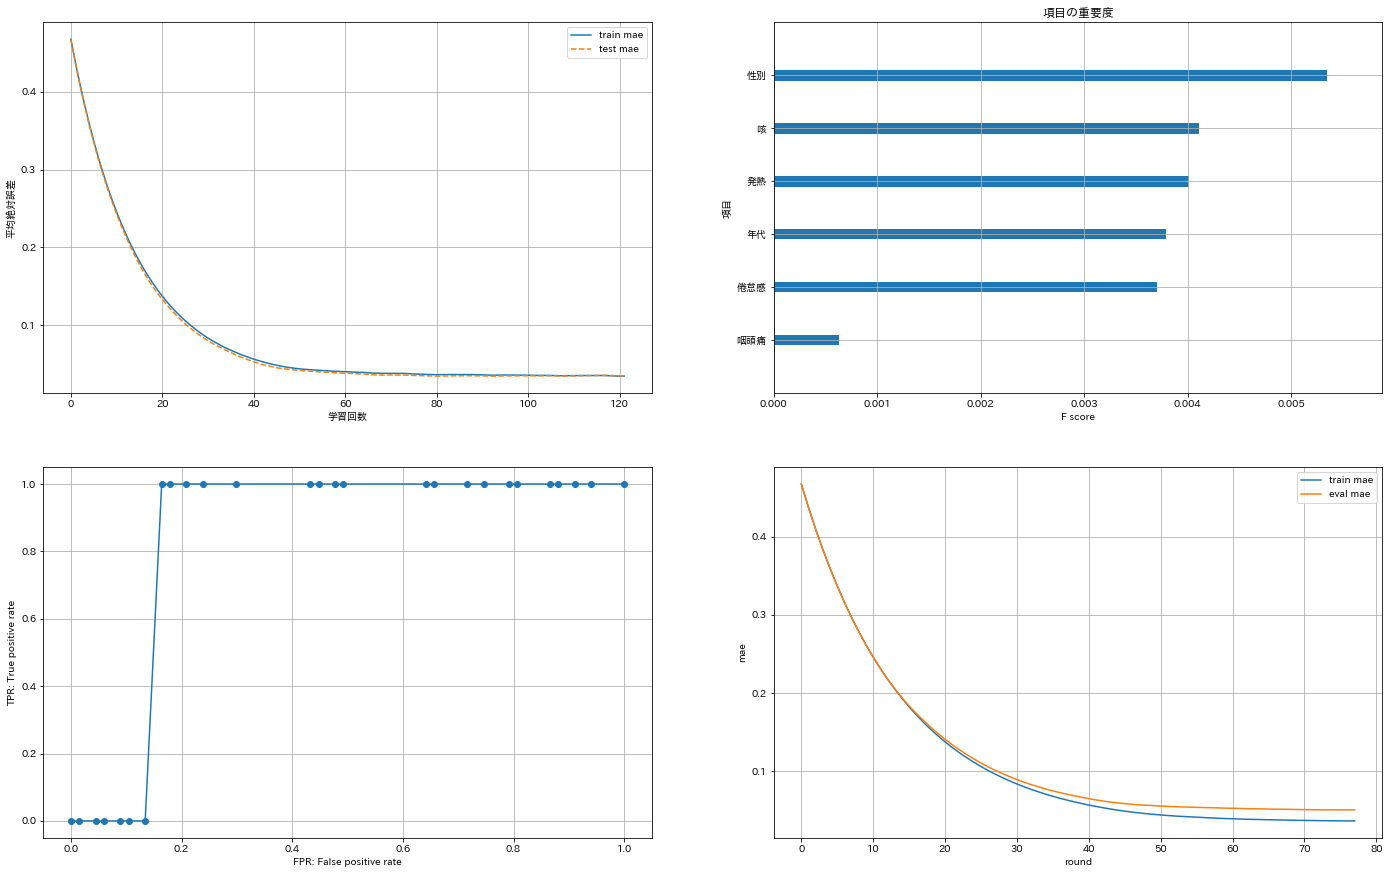

In [42]:
df_new_tokyo = df_new[df_new["都道府県コード"] == 13]
plot_xgboost_result(df_new_tokyo)

In [43]:
warnings.filterwarnings('ignore')
cross_validation(df_new_tokyo)

テストデータのスコア 0.9852941176470589
交差検証のスコア平均 0.9823976608187134
層化k分割交差検証のスコア平均 0.9823391812865497


## 神奈川のみ

[15:28:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

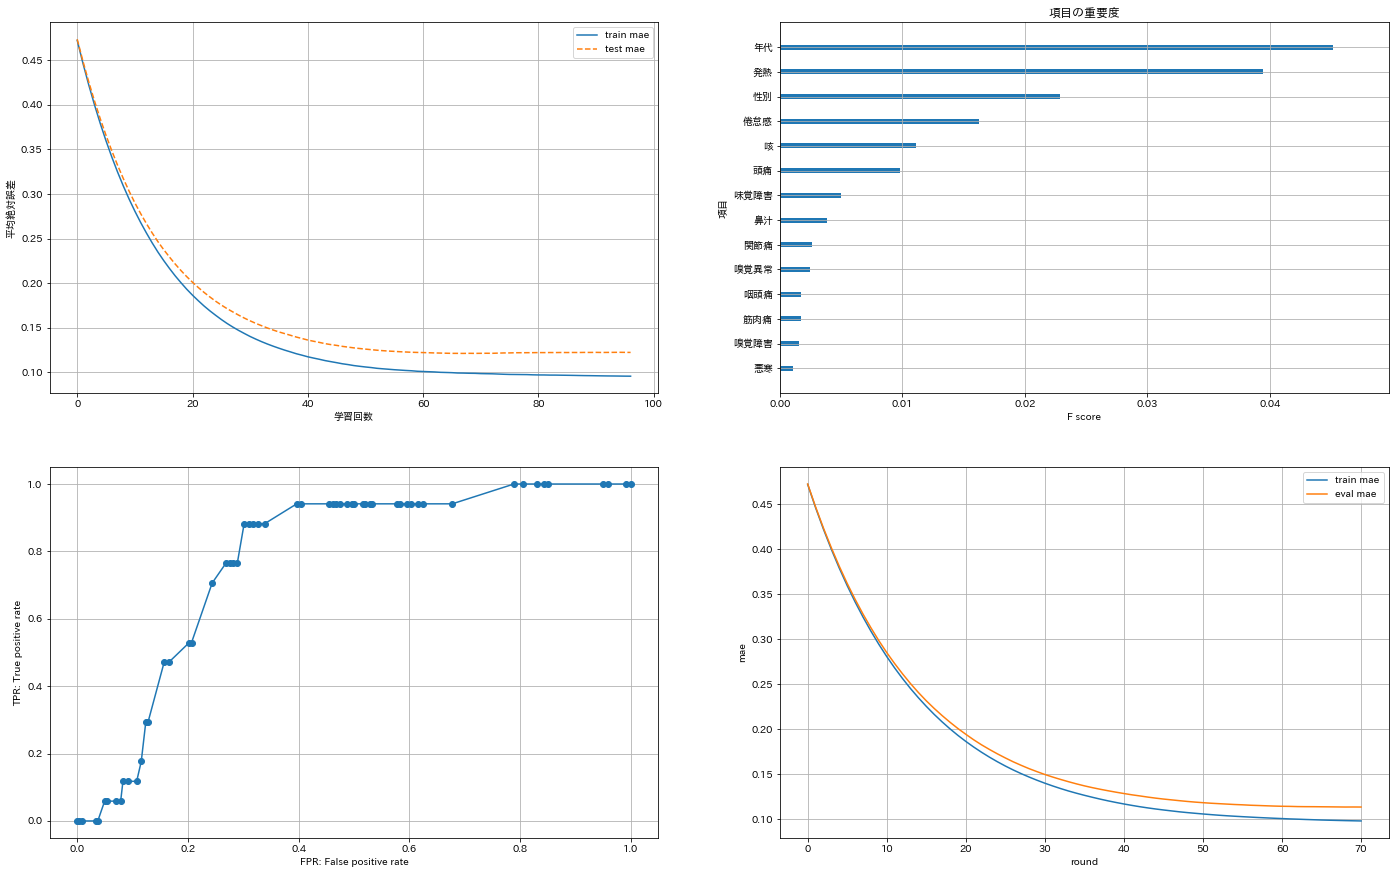

In [44]:
df_new_kanagawa = df_new[df_new["都道府県コード"] == 14]
plot_xgboost_result(df_new_kanagawa)

In [45]:
warnings.filterwarnings('ignore')
cross_validation(df_new_kanagawa)

テストデータのスコア 0.9343629343629344
交差検証のスコア平均 0.9350561362756484
層化k分割交差検証のスコア平均 0.9350359723835333


## 北海道のみ

[15:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

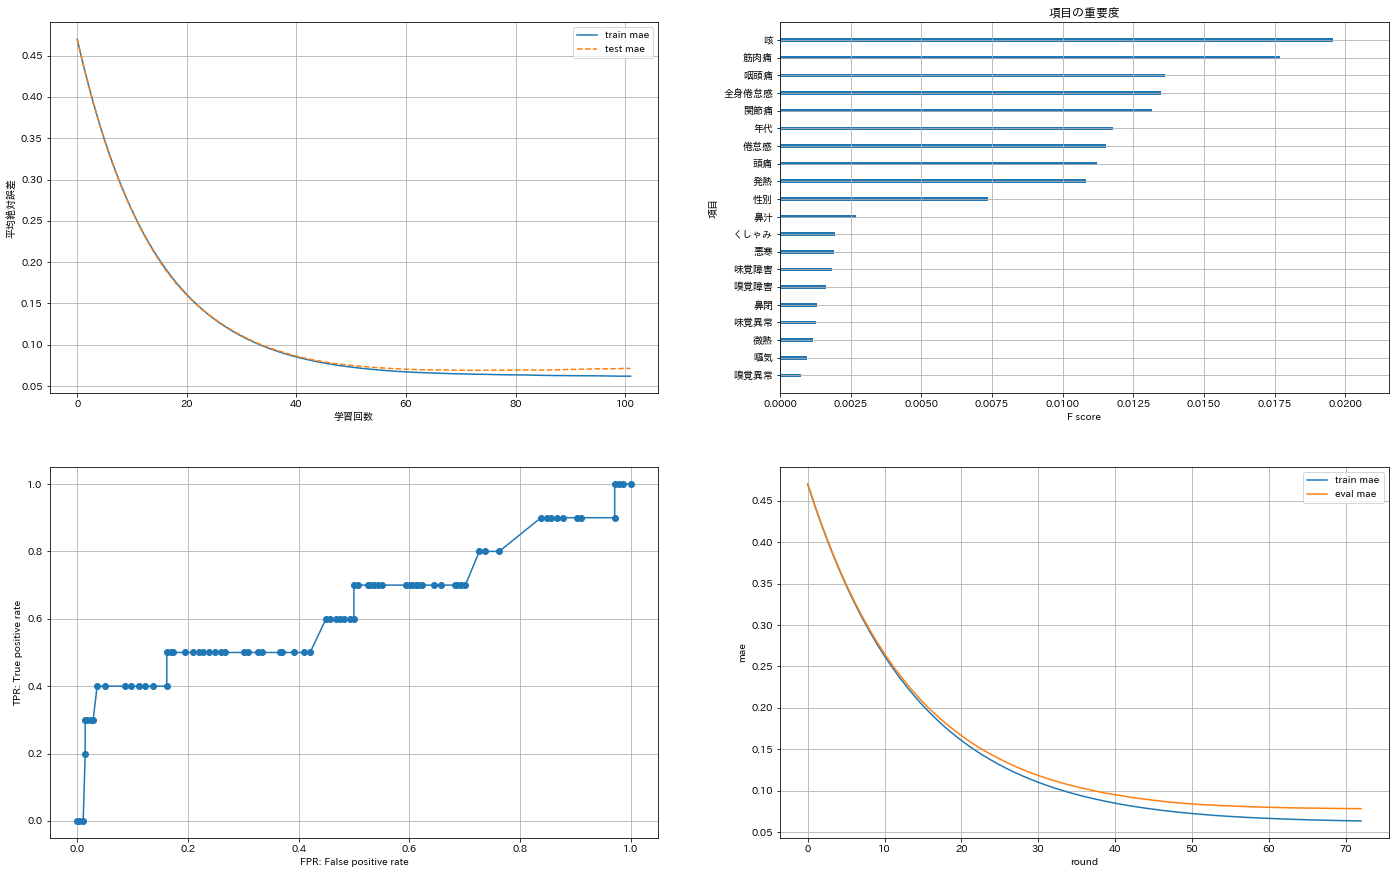

In [46]:
df_new_hokkaido = df_new[df_new["都道府県コード"] == 1]
plot_xgboost_result(df_new_hokkaido)

In [47]:
warnings.filterwarnings('ignore')
cross_validation(df_new_hokkaido)

テストデータのスコア 0.9652777777777778
交差検証のスコア平均 0.9645441483803553
層化k分割交差検証のスコア平均 0.9645114942528736


## 近畿地方

[15:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

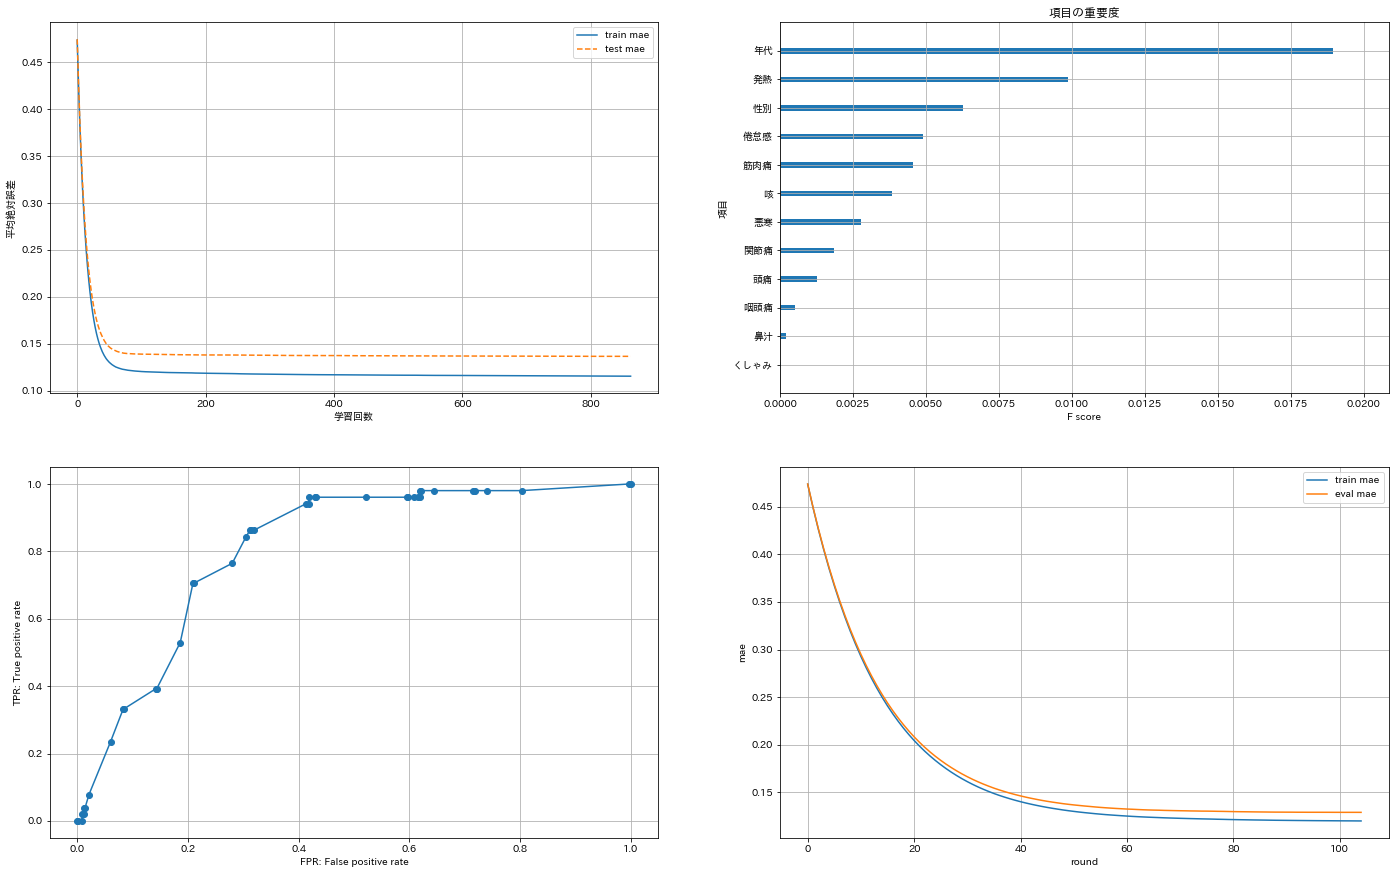

In [48]:
df_new_kinki = df_new[(df_new["都道府県コード"] == 24) | (df_new["都道府県コード"] == 25) | (df_new["都道府県コード"] == 26) | (df_new["都道府県コード"] == 27) | (df_new["都道府県コード"] == 28) | (df_new["都道府県コード"] == 29) | (df_new["都道府県コード"] == 30)]
plot_xgboost_result(df_new_kinki)

In [49]:
warnings.filterwarnings('ignore')
cross_validation(df_new_kinki)

テストデータのスコア 0.9170731707317074
交差検証のスコア平均 0.9174420252208001
層化k分割交差検証のスコア平均 0.9174405940098095


## 関東地方

[15:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

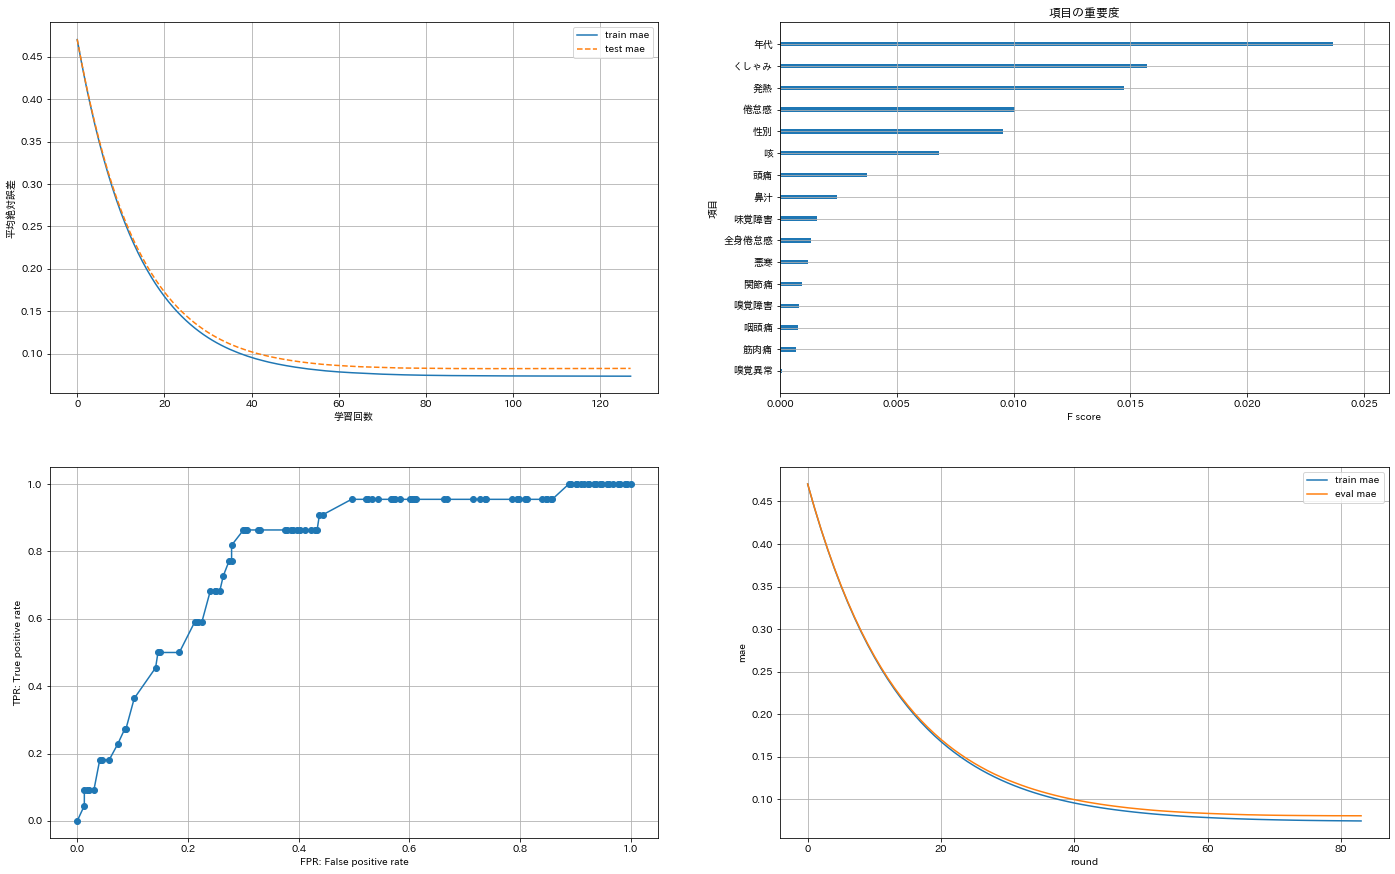

In [50]:
df_new_kanto = df_new[(df_new["都道府県コード"] == 8) | (df_new["都道府県コード"] == 9) | (df_new["都道府県コード"] == 10) | (df_new["都道府県コード"] == 11) | (df_new["都道府県コード"] == 12) | (df_new["都道府県コード"] == 13) | (df_new["都道府県コード"] == 14)]
plot_xgboost_result(df_new_kanto)

In [51]:
warnings.filterwarnings('ignore')
cross_validation(df_new_kanto)

テストデータのスコア 0.9549180327868853
交差検証のスコア平均 0.9556513494894653
層化k分割交差検証のスコア平均 0.9556649910306866


## 中部地方

[15:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

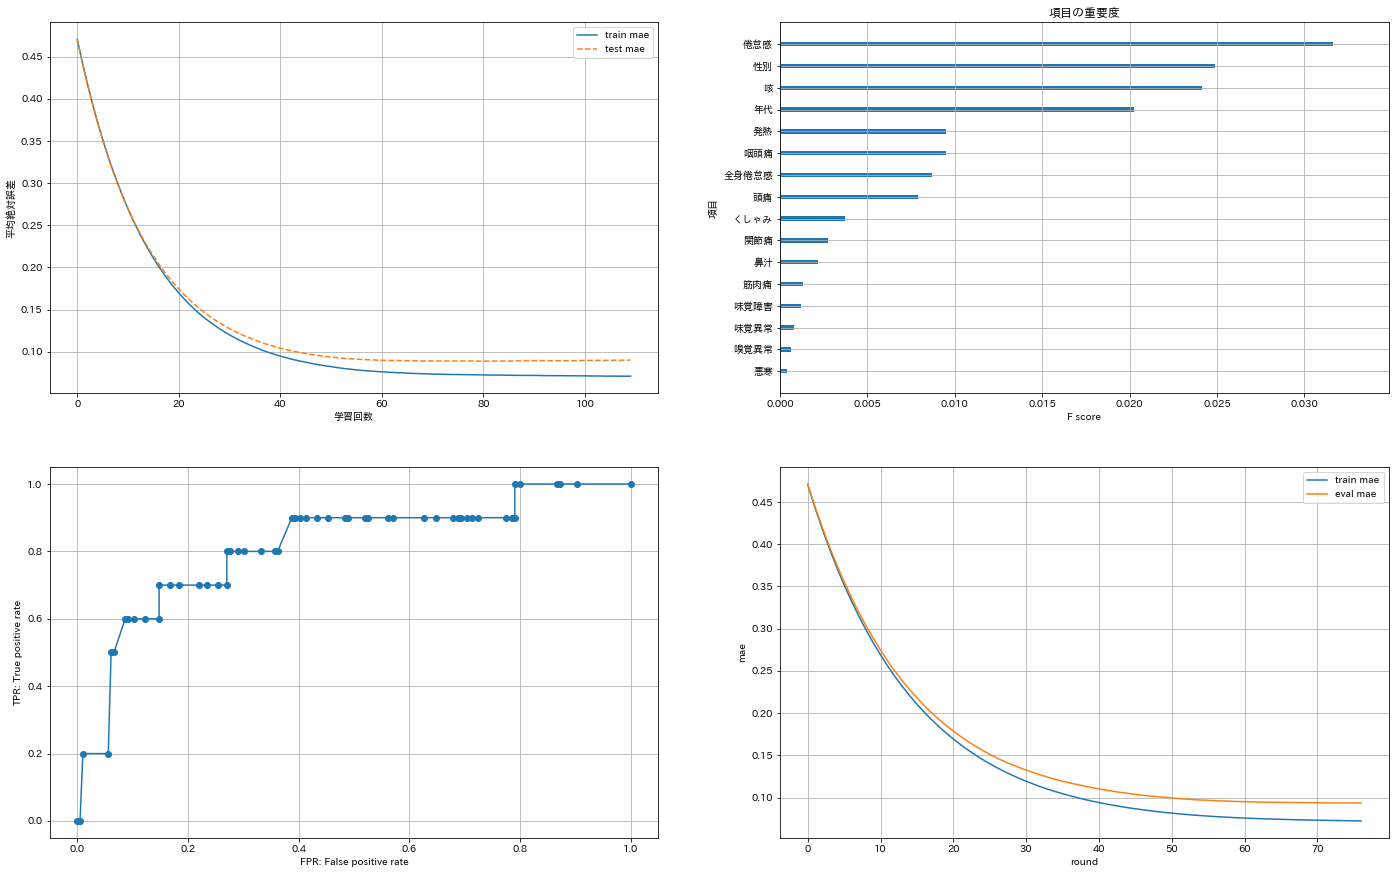

In [52]:
df_new_chubu = df_new[(df_new["都道府県コード"] == 15) | (df_new["都道府県コード"] == 16) | (df_new["都道府県コード"] == 17) | (df_new["都道府県コード"] == 18) | (df_new["都道府県コード"] == 19) | (df_new["都道府県コード"] == 20) | (df_new["都道府県コード"] == 21) | (df_new["都道府県コード"] == 22) | (df_new["都道府県コード"] == 23)]
plot_xgboost_result(df_new_chubu)

In [53]:
warnings.filterwarnings('ignore')
cross_validation(df_new_chubu)

テストデータのスコア 0.9514563106796117
交差検証のスコア平均 0.9517543859649124
層化k分割交差検証のスコア平均 0.9517543859649122


## 九州地方


In [54]:
df_new_kyushu = df_new[(df_new["都道府県コード"] == 40) | (df_new["都道府県コード"] == 41) | (df_new["都道府県コード"] == 42) | (df_new["都道府県コード"] == 43) | (df_new["都道府県コード"] == 44) | (df_new["都道府県コード"] == 45) | (df_new["都道府県コード"] == 46) | (df_new["都道府県コード"] == 47)]
# plot_xgboost_result(df_new_kyushu)

## 四国地方

In [55]:
df_new_shikoku = df_new[(df_new["都道府県コード"] == 36) | (df_new["都道府県コード"] == 37) | (df_new["都道府県コード"] == 38) | (df_new["都道府県コード"] == 39)]
# plot_xgboost_result(df_new_shikoku)

## 東北地方

In [56]:
df_new_tohoku = df_new[(df_new["都道府県コード"] == 2) | (df_new["都道府県コード"] == 3) | (df_new["都道府県コード"] == 4) | (df_new["都道府県コード"] == 5) | (df_new["都道府県コード"] == 6) | (df_new["都道府県コード"] == 7)]
# plot_xgboost_result(df_new_tohoku)

## 中国地方

In [57]:
df_new_chugoku = df_new[(df_new["都道府県コード"] == 31) | (df_new["都道府県コード"] == 32) | (df_new["都道府県コード"] == 33) | (df_new["都道府県コード"] == 34) | (df_new["都道府県コード"] == 35)]
# plot_xgboost_result(df_new_chugoku)